In [125]:
import pandas as pd
import seaborn as sns 
from matplotlib import pyplot as plt

# Data

In [80]:
reference_assembly = '../data/NC_059190.1_ref.fna'
reference_annotaton = '../data/NC_059190.1_RefSeq.gff' 
# nanopore_reads 
geneid_parameters = "../data/Daphnia_magna.param"
isoquant_models = "../data/NC_059190.1_isquant_models.gff"

# Get geneid

In [83]:
! wget https://github.com/guigolab/geneid/archive/refs/heads/master.zip

--2025-05-15 19:43:41--  https://github.com/guigolab/geneid/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/guigolab/geneid/zip/refs/heads/master [following]
--2025-05-15 19:43:42--  https://codeload.github.com/guigolab/geneid/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.121.9
Connecting to codeload.github.com (codeload.github.com)|140.82.121.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [         <=>        ]  15.92M  7.90MB/s    in 2.0s    

2025-05-15 19:43:44 (7.90 MB/s) - ‘master.zip’ saved [16696283]



In [84]:
! unzip master.zip

Archive:  master.zip
5e01c2a3da3da15795f13fb34b0571b217c6f7ed
   creating: /Users/fzanarello/work/projects/summer_school/practicals/day2/fabio/notebook/geneid-master
  inflating: geneid-master/.gitignore  
  inflating: geneid-master/GNU_PL    
  inflating: geneid-master/Makefile  
  inflating: geneid-master/README.md  
  inflating: geneid-master/README.software_geneid  
   creating: /Users/fzanarello/work/projects/summer_school/practicals/day2/fabio/notebook/geneid-master/bin
  inflating: geneid-master/bin/geneid  
   creating: /Users/fzanarello/work/projects/summer_school/practicals/day2/fabio/notebook/geneid-master/docker
  inflating: geneid-master/docker/Dockerfile  
   creating: /Users/fzanarello/work/projects/summer_school/practicals/day2/fabio/notebook/geneid-master/docs
   creating: /Users/fzanarello/work/projects/summer_school/practicals/day2/fabio/notebook/geneid-master/docs/chapter1
  inflating: geneid-master/docs/chapter1/index.html  
   creating: /Users/fzanarello/work/proj

In [85]:
! cd geneid-master/ && make

mkdir ./objects; 
gcc -c -I./include -Wall -O3 ./src/geneid.c -o ./objects/geneid.o 
gcc -c -I./include -Wall -O3 ./src/BackupGenes.c -o ./objects/BackupGenes.o
./src/BackupGenes.c:109:18: warning: equality comparison
      with extraneous parentheses [-Wparentheses-equality]
  109 |   if ((E->Strand == '*')) /* ||(E->Strand != '+')||(E->Strand != '-')) */
      |        ~~~~~~~~~~^~~~~~
./src/BackupGenes.c:109:18: note: remove extraneous
      parentheses around the comparison to silence this warning
  109 |   if ((E->Strand == '*')) /* ||(E->Strand != '+')||(E->Strand != '-')) */
      |       ~          ^     ~
./src/BackupGenes.c:109:18: note: use '=' to turn this
      equality comparison into an assignment
  109 |   if ((E->Strand == '*')) /* ||(E->Strand != '+')||(E->Strand != '-')) */
      |                  ^~
      |                  =
1 warning generated.
gcc -c -I./include -Wall -O3 ./src/PeakEdgeScore.c -o ./objects/PeakEdgeScore.o
gcc -c -I./include -Wall -O3 ./src/GetTr

In [86]:
! ./geneid-master/bin/geneid

Error: One filename is required (DNA sequence, Fasta format)
NAME
	geneid - a program to annotate genomic sequences
SYNOPSIS
	geneid	[-bdaefitnxszru]
		[-TDAZU]
		[-p gene_prefix]
		[-G] [-3] [-X] [-M] [-m]
		[-WCF] [-o]
		[-j lower_bound_coord]
		[-k upper_bound_coord]
		[-N numer_nt_mapped]
		[-O <gff_exons_file>]
		[-R <gff_annotation-file>]
		[-S <gff_homology_file>]
		[-P <parameter_file>]
		[-E exonweight]
		[-V evidence_exonweight]
		[-Bv] [-h]
		<locus_seq_in_fasta_format>
RELEASE
	geneid v 1.4



In [87]:
# create a valiable with geneid executable path
# in a real case scenario, add it to your PATH
geneid = './geneid-master/bin/geneid'

# Predict genes with geneid

In [88]:
! time $geneid -3P $geneid_parameters $reference_assembly > ../results/geneid_simple.gff3

./geneid-master/bin/geneid -3P ../data/Daphnia_magna.param  >   5.83s user 0.13s system 99% cpu 6.009 total


#### Check simple stats

In [66]:
! grep -v '#' ../results/geneid_simple.gff3 | cut -f 3 | sort | uniq -c 

  13296 CDS
  13296 exon
   2914 gene
   2914 mRNA


In [67]:
! bash ../scripts/extract_features.sh 

Usage: ../scripts/extract_features.sh <gff_file> <fasta_file/genome_size_in_bp>


In [68]:
! bash ../scripts/extract_features.sh ../results/geneid_simple.gff3 $reference_assembly

Feature	Features_Count	Total_Feature_Length	Average_Feature_Length	Genome_Percentage
mRNA	2914	7203206	2471.93	69.98
exon	13296	3463047	260.46	33.65
CDS	13296	3463047	260.46	33.65
gene	2914	7203206	2471.93	69.98


In [69]:
13296/2914

4.562800274536719

# Build Transcitps models with IsoQuant

```
isoquant.py --reference GCF_020631705.1_ASM2063170v1.1_genomic.fna \
    --fastq Daphniamagna_20241107_PASS_1341_X4_FAZ37207_d860e5dc_TRIMMED.fastq.gz \
    --data_type ont \
    --output results \
    --prefix Daphnia_magna_isoquant_ref_free \
    --threads 8 
```

#### The Isoquant Output

In [ ]:
# results/
# ├── alignment.log
# ├── Daphnia_magna_isoquant_ref_free
# │   ├── aux
# │   │   ├── Daphnia_magna_isoquant_ref_free_Daphniamagna_20241107_PASS_1341_X4_FAZ37207_d860e5dc_TRIMMED_2e0789_acf03b.bam
# │   │   ├── Daphnia_magna_isoquant_ref_free_Daphniamagna_20241107_PASS_1341_X4_FAZ37207_d860e5dc_TRIMMED_2e0789_acf03b.bam.bai
# │   │   └── NC_059190.1_mappings.bam
# │   ├── Daphnia_magna_isoquant_ref_free.corrected_reads.bed.gz
# │   ├── Daphnia_magna_isoquant_ref_free.transcript_model_counts.tsv
# │   ├── Daphnia_magna_isoquant_ref_free.transcript_model_reads.tsv.gz
# │   ├── Daphnia_magna_isoquant_ref_free.transcript_models.agat.log
# │   ├── Daphnia_magna_isoquant_ref_free.transcript_models.gff
# │   ├── Daphnia_magna_isoquant_ref_free.transcript_models.gtf
# │   └── Daphnia_magna_isoquant_ref_free.transcript_model_tpm.tsv
# ├── GCF_020631705.1_ASM2063170v1.1_genomic_k14_idx
# └── isoquant.log

#### Check simple stats

In [6]:
! grep -v '#' $isoquant_models  | cut -f 3 | sort | uniq -c 

5718 exon
 797 gene
1349 transcript


In [10]:
! bash ../scripts/extract_features.sh $isoquant_models $reference_assembly

Feature	Features_Count	Total_Feature_Length	Average_Feature_Length	Genome_Percentage
exon	5718	1185519	207.33	11.52
transcript	1349	5689555	4217.61	55.28
gene	797	3950119	4956.23	38.38


# Inform geneid with IsoQuant models 

### Prepare models

#### Get longest transcript (check --no_check)

In [2]:
! which agat

agat not found


In [33]:
! agat_sp_keep_longest_isoform.pl --gff ../data/NC_059190.1_isquant_models.gff -o ../intermediate/isoquant_longest.gff

docker: Error response from daemon: invalid volume specification: '/host_mnt/Users/fzanarello/work/projects/summer_school/practicals/day2/fabio/notebook:~': invalid mount config for type "bind": invalid mount path: '~' mount path must be absolute.
See 'docker run --help'.


In [11]:
! bash ../scripts/extract_features.sh ../intermediate/isoquant_longest.gff ../data/NC_059190.1_ref.fna

Feature	Features_Count	Total_Feature_Length	Average_Feature_Length	Genome_Percentage
exon	3546	783245	220.88	7.61
gene	797	3950119	4956.23	38.38
transcript	797	3294312	4133.39	32.01


#### Get exons

In [89]:
! awk '$3 == "exon"' ../intermediate/isoquant_longest.gff > ../intermediate/isoquant_exons.gff

In [90]:
! gawk 'BEGIN { FS=OFS="\t" } /^#/ { print; next } { match($9, /transcript_id=([^;]+)/, a); $9 = a[1]; print }' ../intermediate/isoquant_exons.gff > ../intermediate/isoquant_exons_geneid.gff 

In [91]:
! bash ../scripts/extract_features.sh ../intermediate/isoquant_exons_geneid.gff  ../data/NC_059190.1_ref.fna

Feature	Features_Count	Total_Feature_Length	Average_Feature_Length	Genome_Percentage
exon	3546	783245	220.88	7.61


#### Label with geneid categories

In [92]:
from collections import defaultdict
import csv

# Input/output files
input_file = "../intermediate/isoquant_exons_geneid.gff"
output_file = "../intermediate/isoquant_exons_geneid_class.gff"

# Group exons by transcript
transcript_exons = defaultdict(list)
# transcript_exons = {}


with open(input_file) as f:
    for line in f:
        if line.startswith("#") or not line.strip():
            continue
        parts = line.strip().split('\t')
        transcript_id = parts[8].strip()  # Assuming 9th column is just the transcript name
        transcript_exons[transcript_id].append(parts)

# Process and label exons
with open(output_file, 'w', newline='') as out:
    writer = csv.writer(out, delimiter='\t', quoting=csv.QUOTE_NONE, escapechar='\\')

    for transcript, exons in transcript_exons.items():

        strand = exons[0][6] # extract strand from first exon

        if len(exons) == 1:
            exon = exons[0]
            exon[2] = "Single"
            writer.writerow(exon)
        else:
            for i, exon in enumerate(exons):
                if i == 0 :
                    if strand == '+':
                        exon[2] = "First"
                    else:
                        exon[2] = "Terminal"                 
                elif i == len(exons) - 1:
                    if strand == '+':
                        exon[2] = "Terminal"
                    else:
                        exon[2] = "First"
                else:
                    exon[2] = "Internal"
                writer.writerow(exon)

### Predict with geneid and -R parameter

In [93]:
! time geneid -3P ../data/Daphnia_magna.param -R ../intermediate/isoquant_exons_geneid_class.gff ../data/NC_059190.1_ref.fna > ../results/geneid.gff3

Error: Order violation: annotations (starting position 75394):
-->NC_059190.1	IsoQuant	Terminal	72420	74211	.	-	.	transcript8826.NC_059190.1.nnic


geneid -3P ../data/Daphnia_magna.param -R  ../data/NC_059190.1_ref.fna >   0.07s user 0.08s system 93% cpu 0.164 total


#### Split forward and reverse strand and predict separately

In [94]:
! grep '+' ../intermediate/isoquant_exons_geneid_class.gff > ../intermediate/isoquant_exons_geneid_class_FW.gff

In [95]:
! grep '-' ../intermediate/isoquant_exons_geneid_class.gff > ../intermediate/isoquant_exons_geneid_class_RW.gff

##### Forward

In [96]:
! time geneid -3P ../data/Daphnia_magna.param -R ../intermediate/isoquant_exons_geneid_class_FW.gff ../data/NC_059190.1_ref.fna > ../intermediate/geneid_fw.gff3

Error: Order violation: annotations (starting position 149468):
-->NC_059190.1	IsoQuant	First	148639	148954	.	+	.	transcript8984.NC_059190.1.nnic


geneid -3P ../data/Daphnia_magna.param -R  ../data/NC_059190.1_ref.fna >   0.07s user 0.08s system 95% cpu 0.160 total


In [97]:
! grep -A 2 transcript8984.NC_059190.1.nnic ../intermediate/isoquant_exons_geneid_class_FW.gff 

NC_059190.1	IsoQuant	First	148639	148954	.	+	.	transcript8984.NC_059190.1.nnic
NC_059190.1	IsoQuant	Terminal	150560	150624	.	+	.	transcript8984.NC_059190.1.nnic
NC_059190.1	IsoQuant	First	148639	148954	.	+	.	transcript9044.NC_059190.1.nnic
NC_059190.1	IsoQuant	Terminal	150560	150624	.	+	.	transcript9044.NC_059190.1.nnic


In [98]:
! grep -v transcript8984.NC_059190.1.nnic ../intermediate/isoquant_exons_geneid_class_FW.gff > ../intermediate/isoquant_exons_geneid_class_FW.gff

In [99]:
! time geneid -3P ../data/Daphnia_magna.param -R ../intermediate/isoquant_exons_geneid_class_FW.gff ../data/NC_059190.1_ref.fna > ../intermediate/geneid_fw.gff3

geneid -3P ../data/Daphnia_magna.param -R  ../data/NC_059190.1_ref.fna >   8.03s user 0.21s system 99% cpu 8.250 total


In [108]:
! bash ../scripts/extract_features.sh ../intermediate/geneid_fw.gff3 ../data/NC_059190.1_ref.fna

Feature	Features_Count	Total_Feature_Length	Average_Feature_Length	Genome_Percentage
mRNA	2914	7203206	2471.93	69.98
exon	13296	3463047	260.46	33.65
CDS	13296	3463047	260.46	33.65
gene	2914	7203206	2471.93	69.98


##### Reverse

In [100]:
! time geneid -3P ../data/Daphnia_magna.param -R ../intermediate/isoquant_exons_geneid_class_RW.gff ../data/NC_059190.1_ref.fna > ../intermediate/geneid_rw.gff3

Error: Order violation: annotations (starting position 75394):
-->NC_059190.1	IsoQuant	Terminal	72420	74211	.	-	.	transcript8826.NC_059190.1.nnic


geneid -3P ../data/Daphnia_magna.param -R  ../data/NC_059190.1_ref.fna >   0.06s user 0.07s system 95% cpu 0.137 total


In [101]:
! grep -B 5 transcript8826.NC_059190.1.nnic ../intermediate/isoquant_exons_geneid_class_RW.gff 

NC_059190.1	IsoQuant	Terminal	72420	74211	.	-	.	transcript8761.NC_059190.1.nnic
NC_059190.1	IsoQuant	Internal	74311	74386	.	-	.	transcript8761.NC_059190.1.nnic
NC_059190.1	IsoQuant	Internal	75027	75118	.	-	.	transcript8761.NC_059190.1.nnic
NC_059190.1	IsoQuant	Internal	75183	75309	.	-	.	transcript8761.NC_059190.1.nnic
NC_059190.1	IsoQuant	First	75394	75459	.	-	.	transcript8761.NC_059190.1.nnic
NC_059190.1	IsoQuant	Terminal	72420	74211	.	-	.	transcript8826.NC_059190.1.nnic
NC_059190.1	IsoQuant	Internal	74311	74386	.	-	.	transcript8826.NC_059190.1.nnic
NC_059190.1	IsoQuant	Internal	75027	75118	.	-	.	transcript8826.NC_059190.1.nnic
NC_059190.1	IsoQuant	Internal	75183	75309	.	-	.	transcript8826.NC_059190.1.nnic
NC_059190.1	IsoQuant	First	75394	75459	.	-	.	transcript8826.NC_059190.1.nnic


In [102]:
! grep -v transcript8826.NC_059190.1.nnic ../intermediate/isoquant_exons_geneid_class_RW.gff > ../intermediate/isoquant_exons_geneid_class_RW.gff 

In [103]:
! time geneid -3P ../data/Daphnia_magna.param -R ../intermediate/isoquant_exons_geneid_class_RW.gff ../data/NC_059190.1_ref.fna > ../intermediate/geneid_rw.gff3

geneid -3P ../data/Daphnia_magna.param -R  ../data/NC_059190.1_ref.fna >   8.19s user 0.23s system 99% cpu 8.435 total


In [107]:
! bash ../scripts/extract_features.sh ../intermediate/geneid_rw.gff3 ../data/NC_059190.1_ref.fna

Feature	Features_Count	Total_Feature_Length	Average_Feature_Length	Genome_Percentage
mRNA	2914	7203206	2471.93	69.98
exon	13296	3463047	260.46	33.65
CDS	13296	3463047	260.46	33.65
gene	2914	7203206	2471.93	69.98


#### Combine fw and rw

In [105]:
! gffcompare -C -p geneid_informed ../intermediate/geneid_fw.gff3 ../intermediate/geneid_rw.gff3

Loading query file #1: ../intermediate/geneid_fw.gff3
  2914 query transfrags loaded.
Loading query file #2: ../intermediate/geneid_rw.gff3
  2914 query transfrags loaded.


In [106]:
! bash ../scripts/extract_features.sh gffcmp.combined.gtf ../data/NC_059190.1_ref.fna

Feature	Features_Count	Total_Feature_Length	Average_Feature_Length	Genome_Percentage
exon	13200	3463103	262.36	33.65
transcript	2914	7203206	2471.93	69.98


#### Check simple stats

## new approach

### Exons

! awk '$3 == "exon"' ../data/NC_059190.1_isquant_models.gff > ../intervals/exons.gff

In [52]:
! head ../intervals/exons.gff

NC_059190.1	IsoQuant	exon	44612	44976	.	-	.	ID=agat-exon-17432;Parent=transcript8752.NC_059190.1.nnic;exon=7;exon_id=NC_059190.1.6256;gene_id=novel_gene_NC_059190.1_8758;transcript_id=transcript8752.NC_059190.1.nnic
NC_059190.1	IsoQuant	exon	45045	45161	.	-	.	ID=agat-exon-17431;Parent=transcript8752.NC_059190.1.nnic;exon=6;exon_id=NC_059190.1.6255;gene_id=novel_gene_NC_059190.1_8758;transcript_id=transcript8752.NC_059190.1.nnic
NC_059190.1	IsoQuant	exon	45226	45370	.	-	.	ID=agat-exon-17430;Parent=transcript8752.NC_059190.1.nnic;exon=5;exon_id=NC_059190.1.6254;gene_id=novel_gene_NC_059190.1_8758;transcript_id=transcript8752.NC_059190.1.nnic
NC_059190.1	IsoQuant	exon	45440	45640	.	-	.	ID=agat-exon-17429;Parent=transcript8752.NC_059190.1.nnic;exon=4;exon_id=NC_059190.1.6253;gene_id=novel_gene_NC_059190.1_8758;transcript_id=transcript8752.NC_059190.1.nnic
NC_059190.1	IsoQuant	exon	45707	45922	.	-	.	ID=agat-exon-17428;Parent=transcript8752.NC_059190.1.nnic;exon=3;exon_id=NC_059190.1.6252;ge

In [53]:
! bedtools sort -i ../intervals/exons.gff > ../intervals/exons_sorted.gff

In [54]:
! head ../intervals/exons_sorted.gff

NC_059190.1	IsoQuant	exon	44612	44976	.	-	.	ID=agat-exon-17432;Parent=transcript8752.NC_059190.1.nnic;exon=7;exon_id=NC_059190.1.6256;gene_id=novel_gene_NC_059190.1_8758;transcript_id=transcript8752.NC_059190.1.nnic
NC_059190.1	IsoQuant	exon	44612	44976	.	-	.	ID=agat-exon-17437;Parent=transcript8757.NC_059190.1.nnic;exon=6;exon_id=NC_059190.1.6256;gene_id=novel_gene_NC_059190.1_8758;transcript_id=transcript8757.NC_059190.1.nnic
NC_059190.1	IsoQuant	exon	44612	44976	.	-	.	ID=NC_059190.1.6256;Parent=transcript8750.NC_059190.1.nnic;exon=7;exon_id=NC_059190.1.6256;gene_id=novel_gene_NC_059190.1_8758;transcript_id=transcript8750.NC_059190.1.nnic
NC_059190.1	IsoQuant	exon	45045	45161	.	-	.	ID=agat-exon-17431;Parent=transcript8752.NC_059190.1.nnic;exon=6;exon_id=NC_059190.1.6255;gene_id=novel_gene_NC_059190.1_8758;transcript_id=transcript8752.NC_059190.1.nnic
NC_059190.1	IsoQuant	exon	45045	45161	.	-	.	ID=agat-exon-17436;Parent=transcript8757.NC_059190.1.nnic;exon=5;exon_id=NC_059190.1.6255;g

In [55]:
! bedtools genomecov -strand + -bg -i ../intervals/exons_sorted.gff -g ../data/NC_059190.1_ref.fna.fai > ../intervals/exon_coverage_plus.bed
! bedtools genomecov -strand - -bg -i ../intervals/exons_sorted.gff -g ../data/NC_059190.1_ref.fna.fai > ../intervals/exon_coverage_minus.bed

In [56]:
! awk '{print $0 "\t+"}' ../intervals/exon_coverage_plus.bed > ../intervals/exon_coverage_plus_stranded.bed
! awk '{print $0 "\t-"}' ../intervals/exon_coverage_minus.bed > ../intervals/exon_coverage_minus_stranded.bed

In [57]:
! head ../intervals/exon_coverage_plus_stranded.bed

NC_059190.1	50990	51205	1	+
NC_059190.1	51312	51595	1	+
NC_059190.1	76508	76547	2	+
NC_059190.1	76547	76567	3	+
NC_059190.1	76567	76586	4	+
NC_059190.1	76586	76608	3	+
NC_059190.1	76608	76697	1	+
NC_059190.1	76697	76766	4	+
NC_059190.1	76824	76924	4	+
NC_059190.1	76924	76984	1	+


In [58]:
! head ../intervals/exon_coverage_minus_stranded.bed

NC_059190.1	44611	44976	3	-
NC_059190.1	45044	45161	3	-
NC_059190.1	45225	45370	3	-
NC_059190.1	45439	45640	3	-
NC_059190.1	45706	45922	3	-
NC_059190.1	45993	46139	3	-
NC_059190.1	46139	46472	1	-
NC_059190.1	46472	46542	2	-
NC_059190.1	46542	46700	3	-
NC_059190.1	46700	46705	1	-


In [25]:
! cat ../intervals/exon_coverage_plus_stranded.bed ../intervals/exon_coverage_minus_stranded.bed | bedtools sort > ../intervals/exon_coverage_stranded.bed

In [26]:
! head ../intervals/exon_coverage_stranded.bed

NC_059190.1	44611	44976	3	-
NC_059190.1	45044	45161	3	-
NC_059190.1	45225	45370	3	-
NC_059190.1	45439	45640	3	-
NC_059190.1	45706	45922	3	-
NC_059190.1	45993	46139	3	-
NC_059190.1	46139	46472	1	-
NC_059190.1	46472	46542	2	-
NC_059190.1	46542	46700	3	-
NC_059190.1	46700	46705	1	-


In [27]:
! awk 'BEGIN{OFS="\t"} {print $1, "BEDTools", "exon", $2+1, $3, $4, $5, ".", "."}' ../intervals/exon_coverage_stranded.bed > ../intervals/exon_coverage_stranded.gff

In [29]:
! head -n 20 ../intervals/exon_coverage_stranded.gff

NC_059190.1	BEDTools	exon	44612	44976	3	-	.	.
NC_059190.1	BEDTools	exon	45045	45161	3	-	.	.
NC_059190.1	BEDTools	exon	45226	45370	3	-	.	.
NC_059190.1	BEDTools	exon	45440	45640	3	-	.	.
NC_059190.1	BEDTools	exon	45707	45922	3	-	.	.
NC_059190.1	BEDTools	exon	45994	46139	3	-	.	.
NC_059190.1	BEDTools	exon	46140	46472	1	-	.	.
NC_059190.1	BEDTools	exon	46473	46542	2	-	.	.
NC_059190.1	BEDTools	exon	46543	46700	3	-	.	.
NC_059190.1	BEDTools	exon	46701	46705	1	-	.	.
NC_059190.1	BEDTools	exon	47476	47640	1	-	.	.
NC_059190.1	BEDTools	exon	47641	47884	3	-	.	.
NC_059190.1	BEDTools	exon	47885	47950	2	-	.	.
NC_059190.1	BEDTools	exon	47951	47985	3	-	.	.
NC_059190.1	BEDTools	exon	48079	48252	3	-	.	.
NC_059190.1	BEDTools	exon	50991	51205	1	+	.	.
NC_059190.1	BEDTools	exon	51313	51595	1	+	.	.
NC_059190.1	BEDTools	exon	51489	51489	1	-	.	.
NC_059190.1	BEDTools	exon	51490	51894	2	-	.	.
NC_059190.1	BEDTools	exon	51895	51954	1	-	.	.


In [30]:
! geneid -3P ../data/Daphnia_magna.param -S ../intervals/exon_coverage_stranded.gff -u ../data/NC_059190.1_ref.fna > ../results/geneid_S.gff3

In [33]:
! bash ../scripts/extract_features.sh ../results/geneid_S.gff3 ../data/NC_059190.1_ref.fna

Feature	Features_Count	Total_Feature_Length	Average_Feature_Length	Genome_Percentage
mRNA	3055	7349338	2405.68	71.40
exon	15166	3644442	240.30	35.41
CDS	15166	3644442	240.30	35.41
gene	3055	7349338	2405.68	71.40


In [34]:
! bash ../scripts/extract_features.sh ../results/geneid_simple.gff3 ../data/NC_059190.1_ref.fna

Feature	Features_Count	Total_Feature_Length	Average_Feature_Length	Genome_Percentage
mRNA	2914	7203206	2471.93	69.98
exon	13296	3463047	260.46	33.65
CDS	13296	3463047	260.46	33.65
gene	2914	7203206	2471.93	69.98


### Introns

```
# run directly in data folder
docker run -v $PWD:$PWD -w $PWD quay.io/biocontainers/agat:1.4.0--pl5321hdfd78af_0 agat_sp_add_intergenic_regions.pl --gff NC_059190.1_isquant_models.gff --out isoquant_plus_introns.gff
```

In [3]:
! bash ../scripts/extract_features.sh ../data/isoquant_plus_introns.gff ../data/NC_059190.1_ref.fna

Feature	Features_Count	Total_Feature_Length	Average_Feature_Length	Genome_Percentage
exon	5718	1185519	207.33	11.52
intron	4369	4504036	1030.91	43.76
transcript	1349	5689555	4217.61	55.28
gene	797	3950119	4956.23	38.38


In [8]:
! awk '$3 == "intron"' ../data/isoquant_plus_introns.gff > ../intervals/introns.gff
! bedtools sort -i ../intervals/introns.gff > ../intervals/introns_sorted.gff

In [9]:
! head ../intervals/introns.gff

NC_059190.1	IsoQuant	intron	44977	45044	.	-	.	ID=intron_added-3382;Parent=transcript8752.NC_059190.1.nnic;exon=1;exon_id=NC_059190.1.6257;gene_id=novel_gene_NC_059190.1_8758;transcript_id=transcript8752.NC_059190.1.nnic
NC_059190.1	IsoQuant	intron	45162	45225	.	-	.	ID=intron_added-3383;Parent=transcript8752.NC_059190.1.nnic;exon=1;exon_id=NC_059190.1.6257;gene_id=novel_gene_NC_059190.1_8758;transcript_id=transcript8752.NC_059190.1.nnic
NC_059190.1	IsoQuant	intron	45371	45439	.	-	.	ID=intron_added-3384;Parent=transcript8752.NC_059190.1.nnic;exon=1;exon_id=NC_059190.1.6257;gene_id=novel_gene_NC_059190.1_8758;transcript_id=transcript8752.NC_059190.1.nnic
NC_059190.1	IsoQuant	intron	45641	45706	.	-	.	ID=intron_added-3385;Parent=transcript8752.NC_059190.1.nnic;exon=1;exon_id=NC_059190.1.6257;gene_id=novel_gene_NC_059190.1_8758;transcript_id=transcript8752.NC_059190.1.nnic
NC_059190.1	IsoQuant	intron	45923	45993	.	-	.	ID=intron_added-3386;Parent=transcript8752.NC_059190.1.nnic;exon=1;exon_id

In [10]:
! bedtools genomecov -strand + -bg -i ../intervals/introns_sorted.gff -g ../data/NC_059190.1_ref.fna.fai > ../intervals/introns_coverage_plus.bed
! bedtools genomecov -strand - -bg -i ../intervals/introns_sorted.gff -g ../data/NC_059190.1_ref.fna.fai > ../intervals/introns_coverage_minus.bed

In [11]:
! awk '{print $0 "\t+"}' ../intervals/introns_coverage_plus.bed > ../intervals/introns_coverage_plus_stranded.bed
! awk '{print $0 "\t-"}' ../intervals/introns_coverage_minus.bed > ../intervals/introns_coverage_minus_stranded.bed

In [13]:
! head ../intervals/introns_coverage_plus_stranded.bed

NC_059190.1	51205	51312	1	+
NC_059190.1	76586	76608	1	+
NC_059190.1	76608	76697	3	+
NC_059190.1	76766	76824	4	+
NC_059190.1	76924	77015	3	+
NC_059190.1	77113	78249	1	+
NC_059190.1	78371	78434	1	+
NC_059190.1	78434	78785	2	+
NC_059190.1	78981	79055	2	+
NC_059190.1	79126	79207	1	+


In [14]:
! head ../intervals/introns_coverage_minus_stranded.bed

NC_059190.1	44976	45044	3	-
NC_059190.1	45161	45225	3	-
NC_059190.1	45370	45439	3	-
NC_059190.1	45640	45706	3	-
NC_059190.1	45922	45993	3	-
NC_059190.1	46139	46472	2	-
NC_059190.1	46472	46542	1	-
NC_059190.1	47884	47950	1	-
NC_059190.1	47985	48078	3	-
NC_059190.1	51894	51954	1	-


In [31]:
! cat ../intervals/introns_coverage_plus_stranded.bed ../intervals/introns_coverage_minus_stranded.bed | bedtools sort > ../intervals/introns_coverage_stranded.bed

In [40]:
! awk 'BEGIN{OFS="\t"} {print $1, "BEDTools", "Intron", $2+1, $3, $4, $5, ".", "."}' ../intervals/introns_coverage_stranded.bed > ../intervals/introns_coverage_stranded.gff

In [41]:
! head -n 20 ../intervals/introns_coverage_stranded.gff

NC_059190.1	BEDTools	Intron	44977	45044	3	-	.	.
NC_059190.1	BEDTools	Intron	45162	45225	3	-	.	.
NC_059190.1	BEDTools	Intron	45371	45439	3	-	.	.
NC_059190.1	BEDTools	Intron	45641	45706	3	-	.	.
NC_059190.1	BEDTools	Intron	45923	45993	3	-	.	.
NC_059190.1	BEDTools	Intron	46140	46472	2	-	.	.
NC_059190.1	BEDTools	Intron	46473	46542	1	-	.	.
NC_059190.1	BEDTools	Intron	47885	47950	1	-	.	.
NC_059190.1	BEDTools	Intron	47986	48078	3	-	.	.
NC_059190.1	BEDTools	Intron	51206	51312	1	+	.	.
NC_059190.1	BEDTools	Intron	51895	51954	1	-	.	.
NC_059190.1	BEDTools	Intron	52272	52337	2	-	.	.
NC_059190.1	BEDTools	Intron	64716	64779	1	-	.	.
NC_059190.1	BEDTools	Intron	64950	65244	1	-	.	.
NC_059190.1	BEDTools	Intron	66122	66203	1	-	.	.
NC_059190.1	BEDTools	Intron	66420	66480	1	-	.	.
NC_059190.1	BEDTools	Intron	74212	74310	2	-	.	.
NC_059190.1	BEDTools	Intron	74387	75026	2	-	.	.
NC_059190.1	BEDTools	Intron	75119	75182	2	-	.	.
NC_059190.1	BEDTools	Intron	75310	75393	2	-	.	.


In [42]:
! geneid -3P ../data/Daphnia_magna.param -R ../intervals/introns_coverage_stranded.gff ../data/NC_059190.1_ref.fna > ../results/geneid_R.gff3

In [86]:
! bash ../scripts/extract_features.sh ../results/geneid_R.gff3 ../data/NC_059190.1_ref.fna

Feature	Features_Count	Total_Feature_Length	Average_Feature_Length	Genome_Percentage
mRNA	2964	7204372	2430.62	69.99
exon	13609	3484242	256.02	33.85
CDS	13609	3484242	256.02	33.85
gene	2964	7204372	2430.62	69.99


In [87]:
! bash ../scripts/extract_features.sh ../results/geneid_simple.gff3 ../data/NC_059190.1_ref.fna

Feature	Features_Count	Total_Feature_Length	Average_Feature_Length	Genome_Percentage
mRNA	2914	7203206	2471.93	69.98
exon	13296	3463047	260.46	33.65
CDS	13296	3463047	260.46	33.65
gene	2914	7203206	2471.93	69.98


### Combine exons and introns

In [46]:
! geneid -3P ../data/Daphnia_magna.param -R ../intervals/introns_coverage_stranded.gff -S ../intervals/exon_coverage_stranded.gff -u ../data/NC_059190.1_ref.fna > ../results/geneid_RS.gff3

In [47]:
! bash ../scripts/extract_features.sh ../results/geneid_RS.gff3 ../data/NC_059190.1_ref.fna

Feature	Features_Count	Total_Feature_Length	Average_Feature_Length	Genome_Percentage
mRNA	3035	7397495	2437.40	71.87
exon	15176	3636948	239.65	35.34
CDS	15176	3636948	239.65	35.34
gene	3035	7397495	2437.40	71.87


In [48]:
! bash ../scripts/extract_features.sh ../results/geneid_simple.gff3 ../data/NC_059190.1_ref.fna

Feature	Features_Count	Total_Feature_Length	Average_Feature_Length	Genome_Percentage
mRNA	2914	7203206	2471.93	69.98
exon	13296	3463047	260.46	33.65
CDS	13296	3463047	260.46	33.65
gene	2914	7203206	2471.93	69.98


### Predict UTRs
Note the different parameter file

In [20]:
! geneid -3P ../data/Daphnia_magna.utr.param ../data/NC_059190.1_ref.fna > ../results/geneid_simple_utr.gff3
! geneid -3P ../data/Daphnia_magna.utr.param -S ../intervals/exon_coverage_stranded.gff -u ../data/NC_059190.1_ref.fna > ../results/geneid_S_utr.gff3
! geneid -3P ../data/Daphnia_magna.utr.param -R ../intervals/introns_coverage_stranded.gff ../data/NC_059190.1_ref.fna > ../results/geneid_R_utr.gff3
! geneid -3P ../data/Daphnia_magna.utr.param -R ../intervals/introns_coverage_stranded.gff -S ../intervals/exon_coverage_stranded.gff -u ../data/NC_059190.1_ref.fna > ../results/geneid_RS_utr.gff3

# Compare results

In [77]:
! ls ../results/
res = ! ls ../results/

geneid_R_utr.gff3              ministat_geneid_R.tsv
geneid_R.gff3                  ministat_geneid_RS_utr.tsv
geneid_RS_utr.gff3             ministat_geneid_RS.tsv
geneid_RS.gff3                 ministat_geneid_S_utr.tsv
geneid_S_utr.gff3              ministat_geneid_S.tsv
geneid_S.gff3                  ministat_geneid_simple_utr.tsv
geneid_simple_utr.gff3         ministat_geneid_simple.tsv
geneid_simple.gff3             ministat_refseq.tsv
ministat_geneid_R_utr.tsv


In [78]:
import pandas as pd

res_df = pd.DataFrame()

for r in res:
    if 'gff' in r:
        ministats = f'ministat_{r.replace('gff3', 'tsv')}'
        ! bash ../scripts/extract_features.sh ../results/$r ../data/NC_059190.1_ref.fna > ../results/$ministats
        
        tmp = pd.read_csv(f'../results/{ministats}', sep = '\t')
        tmp['sample'] = r.replace('.gff3', '').split('_')[1]
        if 'utr' in r:
            tmp['utr'] = 'yes'
        else:
            tmp['utr'] = 'no'
        tmp = tmp.melt(id_vars=['sample','Feature','utr'], value_vars=['Features_Count','Total_Feature_Length','Average_Feature_Length','Genome_Percentage'])
        
        res_df = pd.concat([res_df, tmp])

! bash ../scripts/extract_features.sh ../data/NC_059190.1_RefSeq.gff ../data/NC_059190.1_ref.fna > ../results/ministat_refseq.tsv
tmp = pd.read_csv(f'../results/ministat_refseq.tsv', sep = '\t')
tmp['sample'] = 'RefSeq'
tmp['utr'] = 'no'
tmp = tmp.melt(id_vars=['sample','Feature','utr'], value_vars=['Features_Count','Total_Feature_Length','Average_Feature_Length','Genome_Percentage'])
res_df = pd.concat([res_df, tmp])

res_df = res_df.reset_index(col_fill=False)

In [79]:
res_df

,index,sample,Feature,utr,variable,value
0,0,R,mRNA,yes,Features_Count,2964.00
1,1,R,exon,yes,Features_Count,13609.00
2,2,R,CDS,yes,Features_Count,13609.00
3,3,R,gene,yes,Features_Count,2964.00
4,4,R,mRNA,yes,Total_Feature_Length,7204372.00
...,...,...,...,...,...,...
175,39,RefSeq,CDS,no,Genome_Percentage,26.45
176,40,RefSeq,pseudogene,no,Genome_Percentage,4.18
177,41,RefSeq,transcript,no,Genome_Percentage,7.87
178,42,RefSeq,tRNA,no,Genome_Percentage,0.51


In [24]:
res_df['Feature'].unique()

array(['mRNA', 'exon', 'CDS', 'gene', 'UTR', 'lnc_RNA', 'snRNA', 'region',
       'cDNA_match', 'pseudogene', 'transcript', 'tRNA'], dtype=object)

In [25]:
res_df['sample'].unique()

array(['R', 'RS', 'S', 'simple', 'RefSeq'], dtype=object)

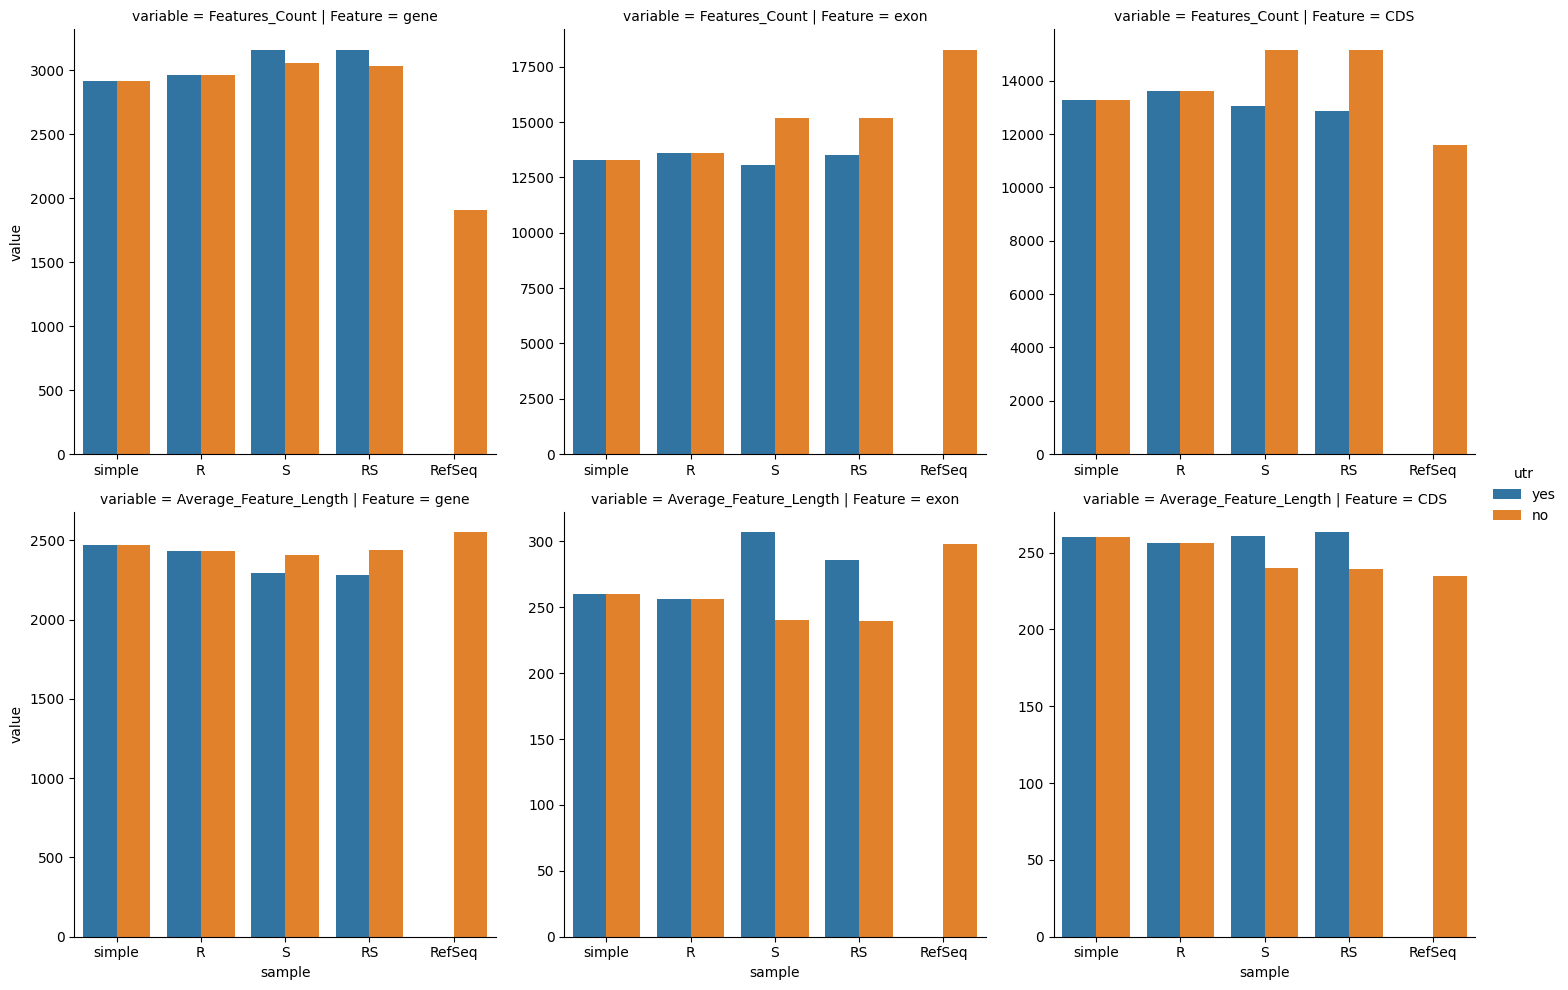

In [32]:
import seaborn as sns

sns.catplot(data = res_df,
           x = 'sample',
           order = ['simple','R','S','RS','RefSeq'],
           y = 'value',
           col = 'Feature',
           col_order = ['gene','exon', 'CDS'],
           row = 'variable',
           row_order = ['Features_Count','Average_Feature_Length'],
           hue = 'utr',
           kind = 'bar', 
           sharey = False,
           sharex = False
           )

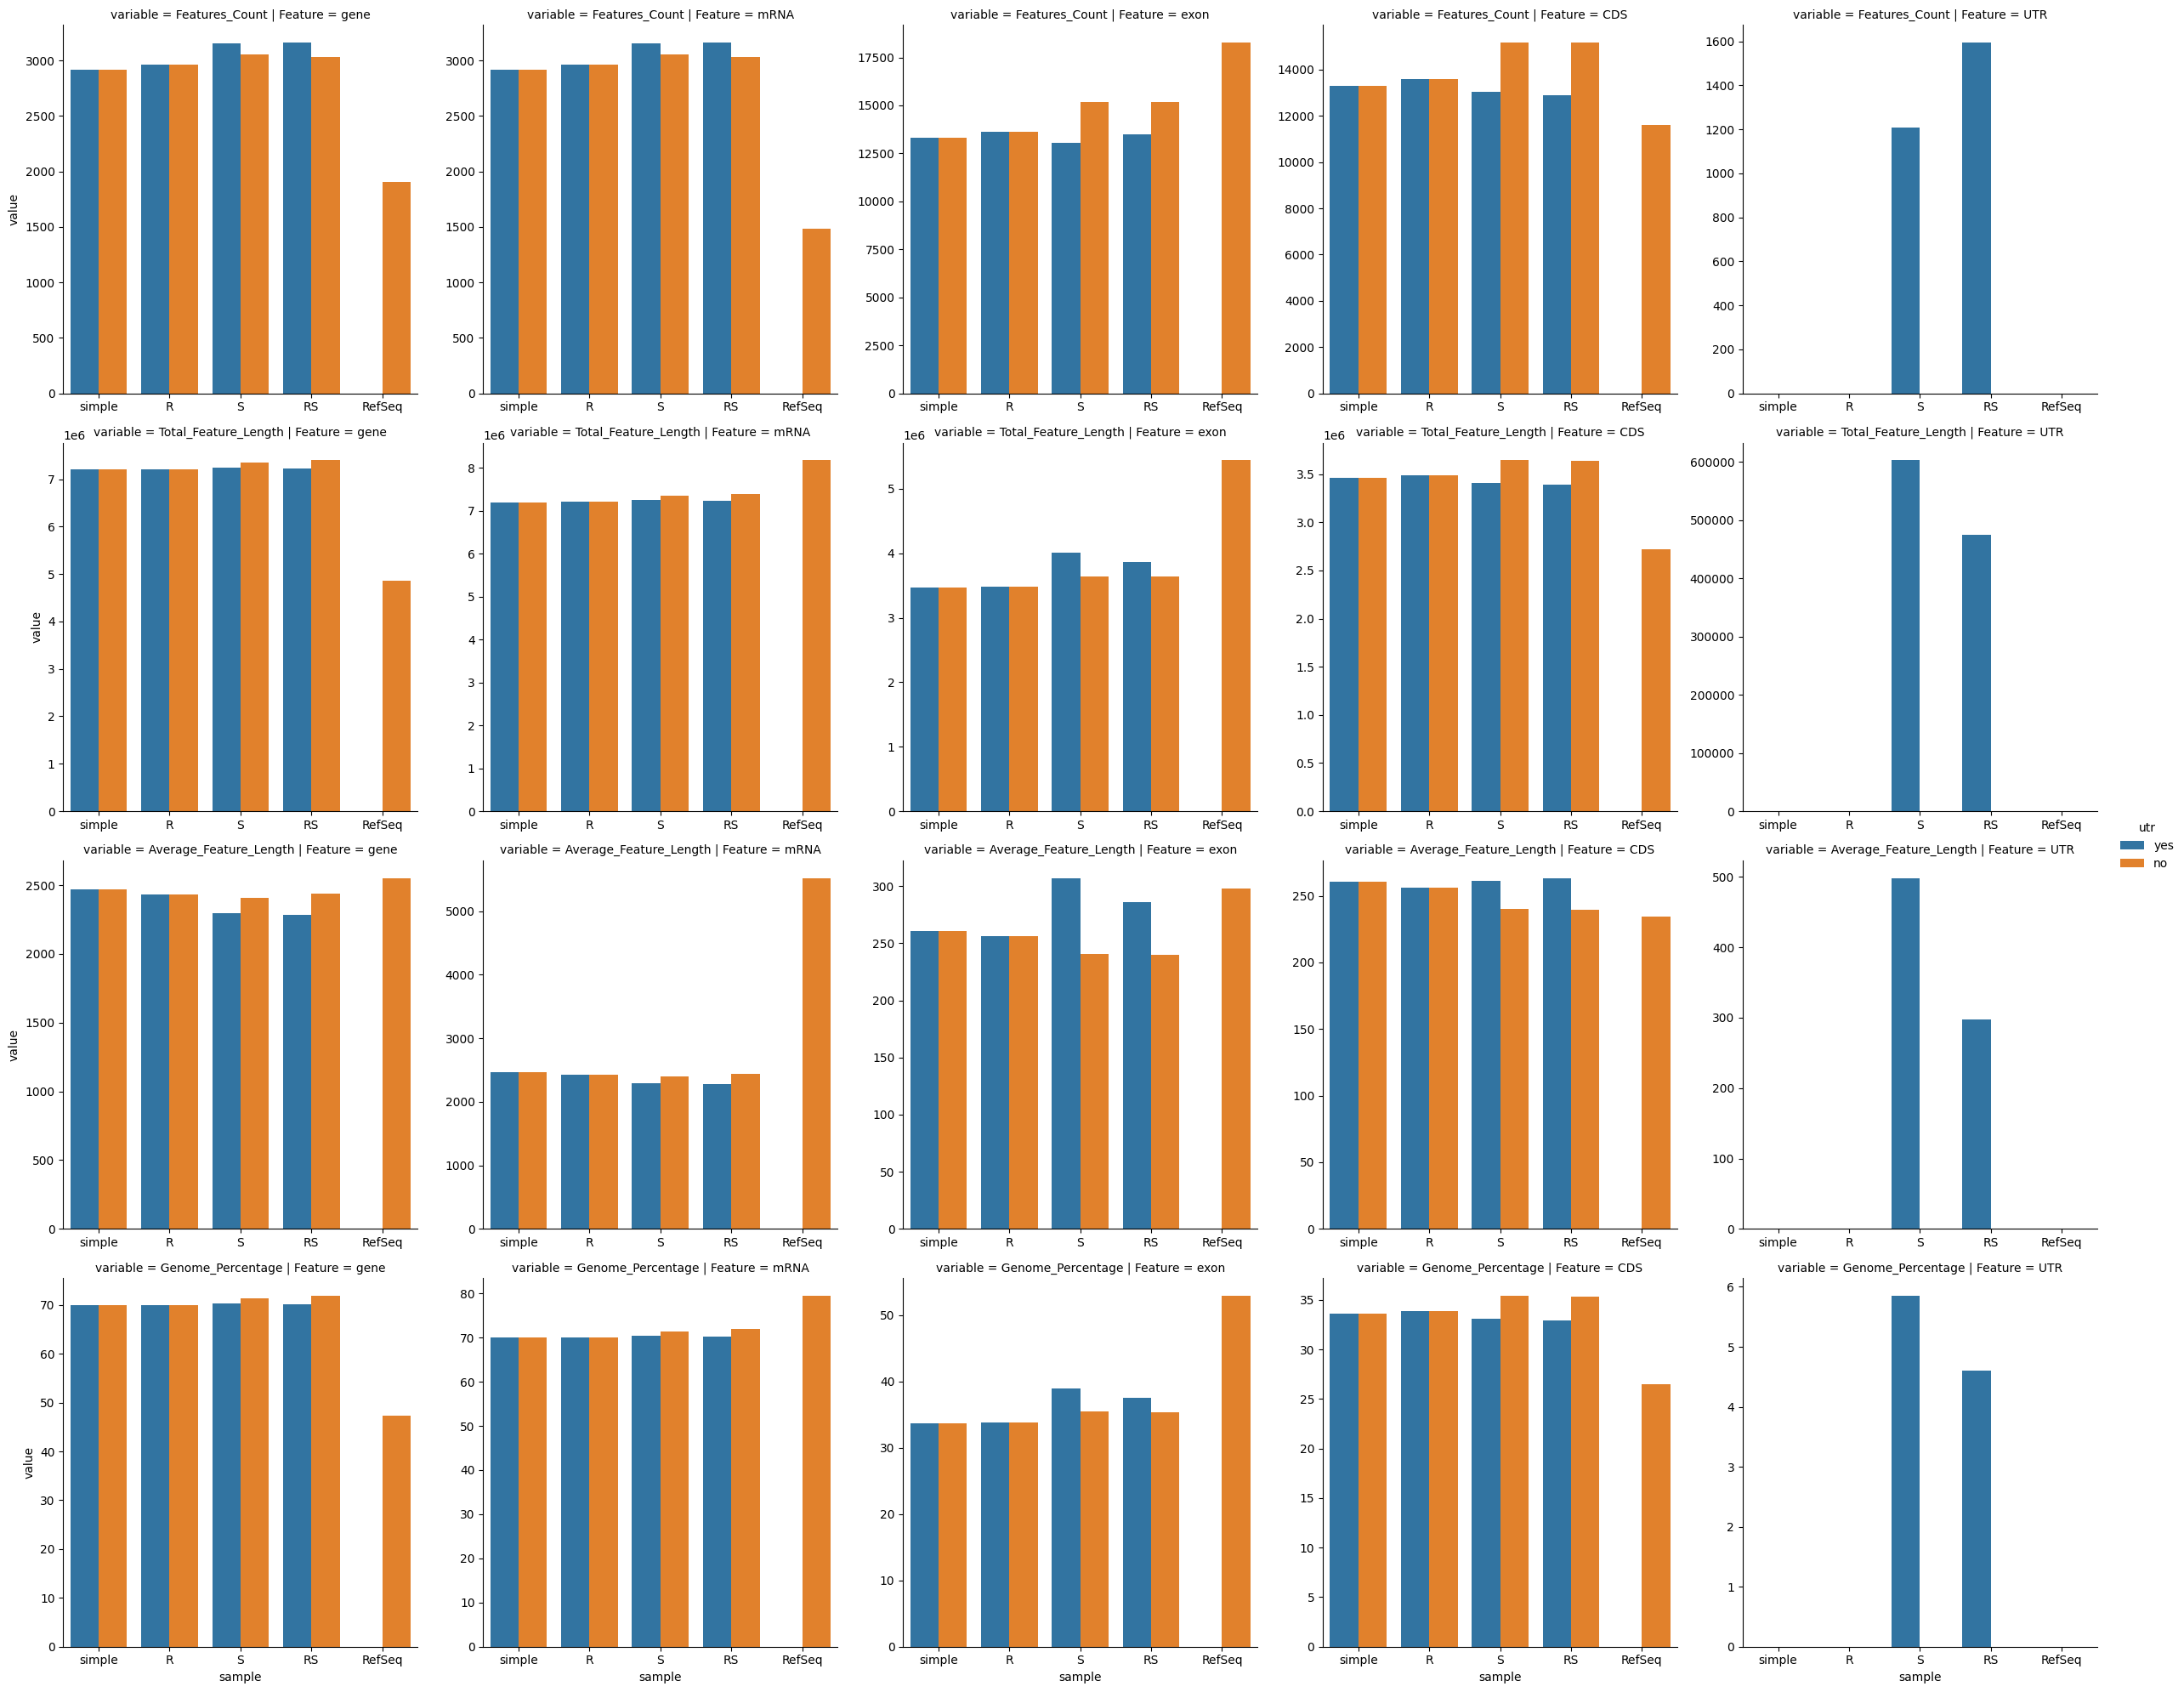

In [31]:
import seaborn as sns

sns.catplot(data = res_df,
           x = 'sample',
           order = ['simple','R','S','RS','RefSeq'],
           y = 'value',
           col = 'Feature',
           col_order = ['gene','mRNA','exon','CDS','UTR'],
           row = 'variable', 
           hue = 'utr',
           kind = 'bar', 
           sharey = False,
           sharex = False
           )

# Run full comparison with compann-nf

### Get reference annotation

#### Get info about the taxon

#### Get annotation for the species of iterest

#### Prepare input

In [ ]:
! mkdir -p ../compann/input
! mkdir -p ../compann/output

In [106]:
! rm -rf ../compann/input/*

In [ ]:
! ln -s ../results/*gff3 ../compann/input
! ln -s ../../data/NC_059190.1_RefSeq.gff ../compann/input/refseq_ref.gff
! ln -s ../../data/NC_059190.1_ref.fna ../compann/input/ref.fa

In [107]:
! ln -s ../results/geneid_R.gff3 ../compann/input/

```
docker run ezlabgva/busco:v5.7.0_cv1 busco --list-datasets
```

### Run Pipeline

```
nextflow run /Users/fzanarello/work/pipelines/compann-nf/main.nf \
        --gff_folder input \
        --outputFolder output \
        --ref $(realpath input/ref.fa) \
        --lineage crustacea_odb12 \
        -resume
```

### Inspect results

In [96]:
! tree ../compann/output/

../compann/output/
├── BUSCO
│   ├── all_samples
│   │   ├── short_summary.specific.crustacea_odb12.BUSCO_geneid_R_transcripts.fa.json
│   │   ├── short_summary.specific.crustacea_odb12.BUSCO_geneid_R_utr_transcripts.fa.json
│   │   ├── short_summary.specific.crustacea_odb12.BUSCO_geneid_RS_transcripts.fa.json
│   │   ├── short_summary.specific.crustacea_odb12.BUSCO_geneid_RS_utr_transcripts.fa.json
│   │   ├── short_summary.specific.crustacea_odb12.BUSCO_geneid_S_transcripts.fa.json
│   │   ├── short_summary.specific.crustacea_odb12.BUSCO_geneid_S_utr_transcripts.fa.json
│   │   ├── short_summary.specific.crustacea_odb12.BUSCO_geneid_simple_transcripts.fa.json
│   │   ├── short_summary.specific.crustacea_odb12.BUSCO_geneid_simple_utr_transcripts.fa.json
│   │   └── short_summary.specific.crustacea_odb12.BUSCO_refseq_ref_transcripts.fa.json
│   └── summary
│       └── combined_BUSCO_results.csv
├── gffcompare
│   ├── all_samples
│   │   ├── geneid_R_longisoforms_200plus_basicelements_V

### Summaries

In [105]:
summary_df = pd.read_csv('../compann/output/summary_stat/summary_stats_combined.csv')

In [107]:
summary_df['label'] = summary_df['File Name'].map(lambda x : x.split('_')[1])
summary_df['UTR'] = summary_df['File Name'].map(lambda x: 'yes' if 'utr' in x else 'no')

In [109]:
for file in sorted(summary_df['File Name'].unique()):
    ft_available = summary_df[summary_df['File Name'] == file]['Type'].unique()
    print (file, ft_available) 

geneid_R ['cds' 'exon' 'gene' 'mrna' 'Total']
geneid_RS ['cds' 'exon' 'gene' 'mrna' 'Total']
geneid_RS_longisoforms_200plus_basicelements ['cds' 'gene' 'mrna' 'Total']
geneid_RS_utr ['cds' 'exon' 'gene' 'mrna' 'utr' 'Total']
geneid_RS_utr_longisoforms_200plus_basicelements ['cds' 'gene' 'mrna' 'Total']
geneid_R_longisoforms_200plus_basicelements ['cds' 'gene' 'mrna' 'Total']
geneid_R_utr ['cds' 'exon' 'gene' 'mrna' 'Total']
geneid_R_utr_longisoforms_200plus_basicelements ['cds' 'gene' 'mrna' 'Total']
geneid_S ['cds' 'exon' 'gene' 'mrna' 'Total']
geneid_S_longisoforms_200plus_basicelements ['cds' 'gene' 'mrna' 'Total']
geneid_S_utr ['cds' 'exon' 'gene' 'mrna' 'utr' 'Total']
geneid_S_utr_longisoforms_200plus_basicelements ['cds' 'gene' 'mrna' 'Total']
geneid_simple ['cds' 'exon' 'gene' 'mrna' 'Total']
geneid_simple_longisoforms_200plus_basicelements ['cds' 'gene' 'mrna' 'Total']
geneid_simple_utr ['cds' 'exon' 'gene' 'mrna' 'Total']
geneid_simple_utr_longisoforms_200plus_basicelements ['

In [112]:
summary_df = summary_df.melt(id_vars=['File Name','Full/200+','Type','label','UTR'],
                value_vars=['Number','Size total (kb)','Size mean (bp)'])

In [113]:
summary_df

,File Name,Full/200+,Type,label,UTR,variable,value
0,geneid_S,Full,cds,S,no,Number,15166.00
1,geneid_S,Full,exon,S,no,Number,15166.00
2,geneid_S,Full,gene,S,no,Number,3055.00
3,geneid_S,Full,mrna,S,no,Number,3055.00
4,geneid_S,Full,Total,S,no,Number,36442.00
...,...,...,...,...,...,...,...
265,geneid_RS_utr_longisoforms_200plus_basicelements,200+,Total,RS,yes,Size mean (bp),990.12
266,geneid_S_utr_longisoforms_200plus_basicelements,200+,cds,S,yes,Size mean (bp),272.82
267,geneid_S_utr_longisoforms_200plus_basicelements,200+,gene,S,yes,Size mean (bp),2602.54
268,geneid_S_utr_longisoforms_200plus_basicelements,200+,mrna,S,yes,Size mean (bp),2602.54


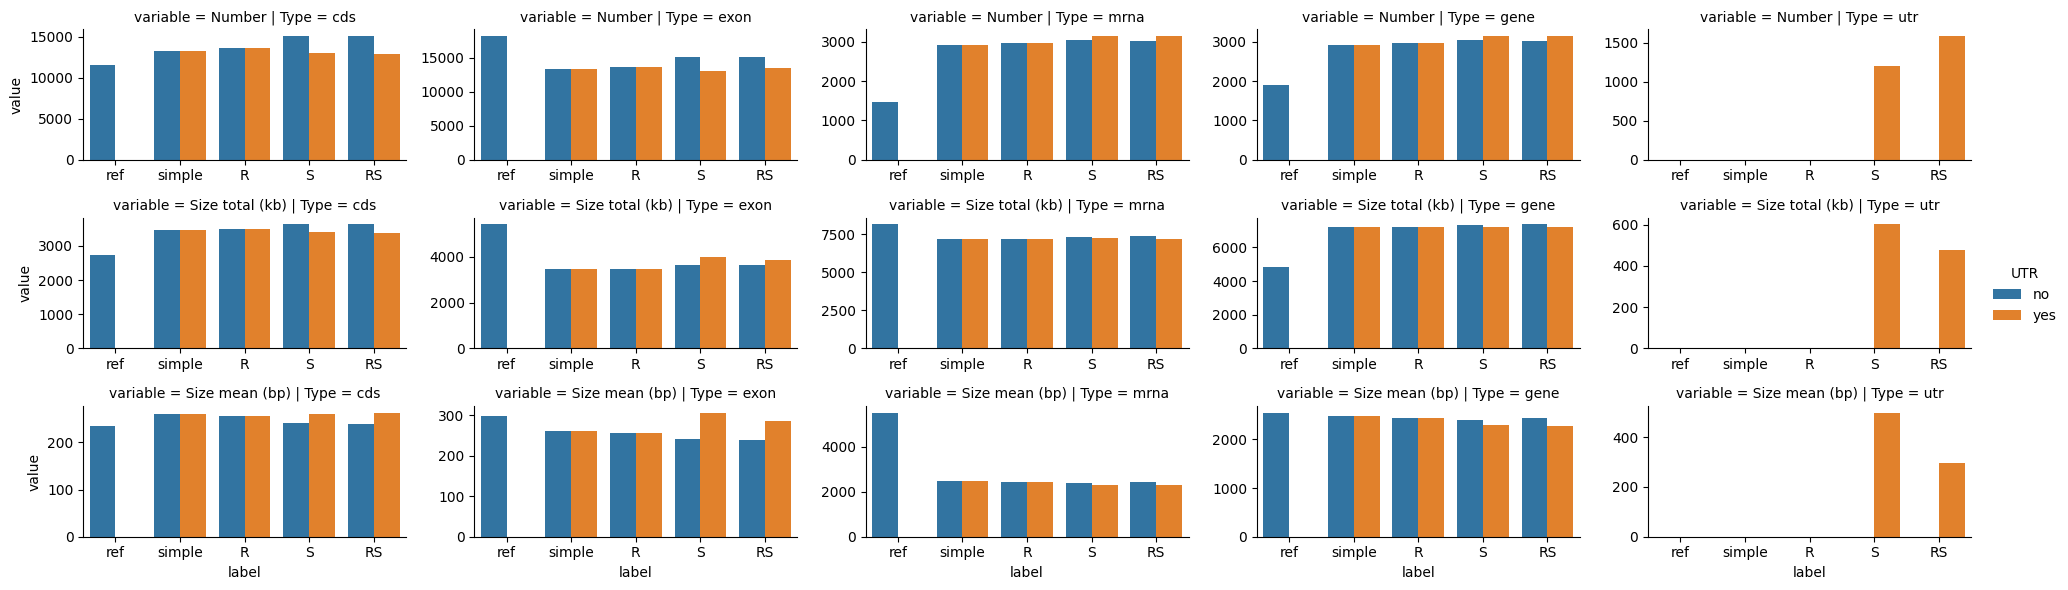

In [122]:
sns.catplot(data = summary_df[summary_df['Full/200+'] == 'Full'],
           x = 'label',
           order = ['ref','simple', 'R', 'S', 'RS'],
           y = 'value',
           row = 'variable',
           col = 'Type',
           col_order=['cds','exon','mrna','gene','utr' ], 
           hue = 'UTR',
           kind = 'bar', 
           sharey = False,
           sharex = False,
           aspect=2, 
           height=2
           )

### Busco

In [10]:
busco_df = pd.read_csv('../compann/output/BUSCO/summary/combined_BUSCO_results.csv')

In [14]:
busco_df

,metric,BUSCO_geneid_simple_transcripts,BUSCO_geneid_RS_transcripts,BUSCO_geneid_R_transcripts,BUSCO_geneid_S_transcripts,BUSCO_refseq_ref_transcripts,BUSCO_geneid_simple_utr_transcripts,BUSCO_geneid_R_utr_transcripts,BUSCO_geneid_RS_utr_transcripts,BUSCO_geneid_S_utr_transcripts
0,one_line_summary,"C:5.1%[S:4.8%,D:0.3%],F:0.9%,M:94.0%,n:1536","C:5.6%[S:5.5%,D:0.1%],F:0.5%,M:93.9%,n:1536","C:5.7%[S:5.3%,D:0.3%],F:0.7%,M:93.7%,n:1536","C:5.6%[S:5.5%,D:0.1%],F:0.6%,M:93.8%,n:1536","C:6.1%[S:3.9%,D:2.1%],F:0.3%,M:93.7%,n:1536","C:5.1%[S:4.8%,D:0.3%],F:0.9%,M:94.0%,n:1536","C:5.7%[S:5.3%,D:0.3%],F:0.7%,M:93.7%,n:1536","C:5.1%[S:4.9%,D:0.2%],F:0.7%,M:94.1%,n:1536","C:4.8%[S:4.6%,D:0.2%],F:1.0%,M:94.1%,n:1536"
1,Complete percentage,5.1,5.6,5.7,5.6,6.1,5.1,5.7,5.1,4.8
2,Complete BUSCOs,78,86,87,86,93,78,87,79,74
3,Single copy percentage,4.8,5.5,5.3,5.5,3.9,4.8,5.3,4.9,4.6
4,Single copy BUSCOs,73,84,82,84,60,73,82,76,71
5,Multi copy percentage,0.3,0.1,0.3,0.1,2.1,0.3,0.3,0.2,0.2
6,Multi copy BUSCOs,5,2,5,2,33,5,5,3,3
7,Fragmented percentage,0.9,0.5,0.7,0.6,0.3,0.9,0.7,0.7,1.0
8,Fragmented BUSCOs,14,8,10,9,4,14,10,11,16
9,Missing percentage,94.0,93.9,93.7,93.8,93.7,94.0,93.7,94.1,94.1


In [15]:
plt_busco_df = busco_df.transpose()
plt_busco_df.index = plt_busco_df.index.map(lambda a : a.replace('BUSCO_','').replace('_transcripts',''))
plt_busco_df.columns = plt_busco_df.iloc[0]
plt_busco_df = plt_busco_df.drop('metric')
plt_busco_df = plt_busco_df[['Complete percentage','Fragmented percentage','Missing percentage']].apply(pd.to_numeric)

In [31]:
desired_order = ['refseq_ref',
                 'geneid_simple', 'geneid_simple_utr', 
                 'geneid_R', 'geneid_R_utr',
                 'geneid_S', 'geneid_S_utr',
                 'geneid_RS', 'geneid_RS_utr' ]

plt_busco_df = plt_busco_df.loc[desired_order]

(0.0, 8.0)

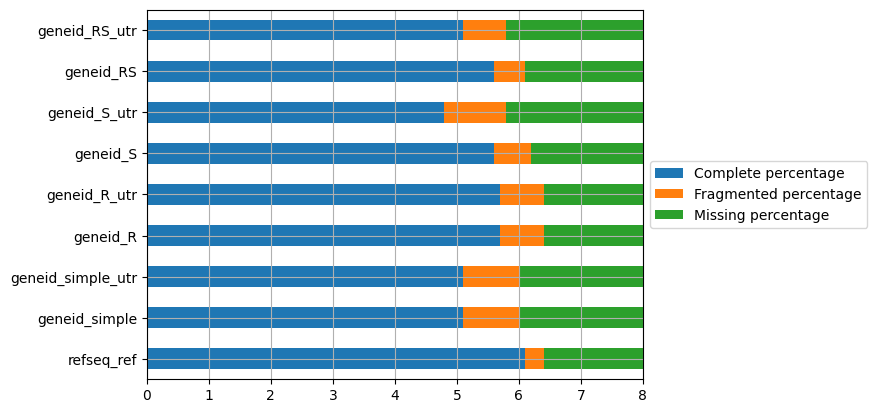

In [32]:
from matplotlib import pyplot as plt 

plt_busco_df.plot(kind='barh', stacked = 'True')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(0,8)

### gff compare

In [86]:
gffcompare_df = pd.read_csv('../compann/output/gffcompare/summary/combined_gffcompare_extend.tsv')

In [87]:
gffcompare_df.variable.unique()

array(['query_mrnas', 'reference_mrnas', 'base_level_Se', 'base_level_Pr',
       'base_level_F1', 'exon_level_Se', 'exon_level_Pr', 'exon_level_F1',
       'transcript_level_Se', 'transcript_level_Pr',
       'transcript_level_F1', 'locus_level_Se', 'locus_level_Pr',
       'locus_level_F1', 'matching_intron_chains', 'matching_transcripts',
       'matching_loci', 'missed_exon_prop', 'missed_exon_perc',
       'novel_exon_prop', 'novel_exon_perc'], dtype=object)

In [88]:
gffcompare_df = gffcompare_df[(gffcompare_df['ref'] == 'refseq_ref') & (gffcompare_df['query'] != 'refseq_ref')]

metrics = ['base_level_Se', 'base_level_Pr','base_level_F1',
           'exon_level_Se', 'exon_level_Pr', 'exon_level_F1',
           'transcript_level_Se', 'transcript_level_Pr', 'transcript_level_F1',
           'locus_level_Se', 'locus_level_Pr','locus_level_F1']

gffcompare_df = gffcompare_df[gffcompare_df['variable'].isin(metrics)]


gffcompare_df['value'] = pd.to_numeric(gffcompare_df['value'])
gffcompare_df['measure'] = gffcompare_df['variable'].map(lambda x : x.split('_')[-1])
gffcompare_df['level'] = gffcompare_df['variable'].map(lambda x : x.split('_')[0])
gffcompare_df['label'] = gffcompare_df['query'].map(lambda x : x.split('_')[1])
gffcompare_df['UTR'] = gffcompare_df['query'].map(lambda x: 'yes' if 'utr' in x else 'no')

In [90]:
gffcompare_df

,comparison,ref,query,variable,value,measure,level,label,UTR
144,refseq_ref_VS_geneid_simple,refseq_ref,geneid_simple,base_level_Se,94.4,Se,base,simple,no
149,refseq_ref_VS_geneid_S,refseq_ref,geneid_S,base_level_Se,93.6,Se,base,S,no
154,refseq_ref_VS_geneid_RS,refseq_ref,geneid_RS,base_level_Se,93.6,Se,base,RS,no
158,refseq_ref_VS_geneid_R,refseq_ref,geneid_R,base_level_Se,93.7,Se,base,R,no
164,refseq_ref_VS_geneid_simple_utr,refseq_ref,geneid_simple_utr,base_level_Se,6.4,Se,base,simple,yes
...,...,...,...,...,...,...,...,...,...
950,refseq_ref_VS_geneid_R,refseq_ref,geneid_R,locus_level_F1,9.9,F1,locus,R,no
956,refseq_ref_VS_geneid_simple_utr,refseq_ref,geneid_simple_utr,locus_level_F1,1.8,F1,locus,simple,yes
973,refseq_ref_VS_geneid_R_utr,refseq_ref,geneid_R_utr,locus_level_F1,9.9,F1,locus,R,yes
978,refseq_ref_VS_geneid_RS_utr,refseq_ref,geneid_RS_utr,locus_level_F1,10.9,F1,locus,RS,yes


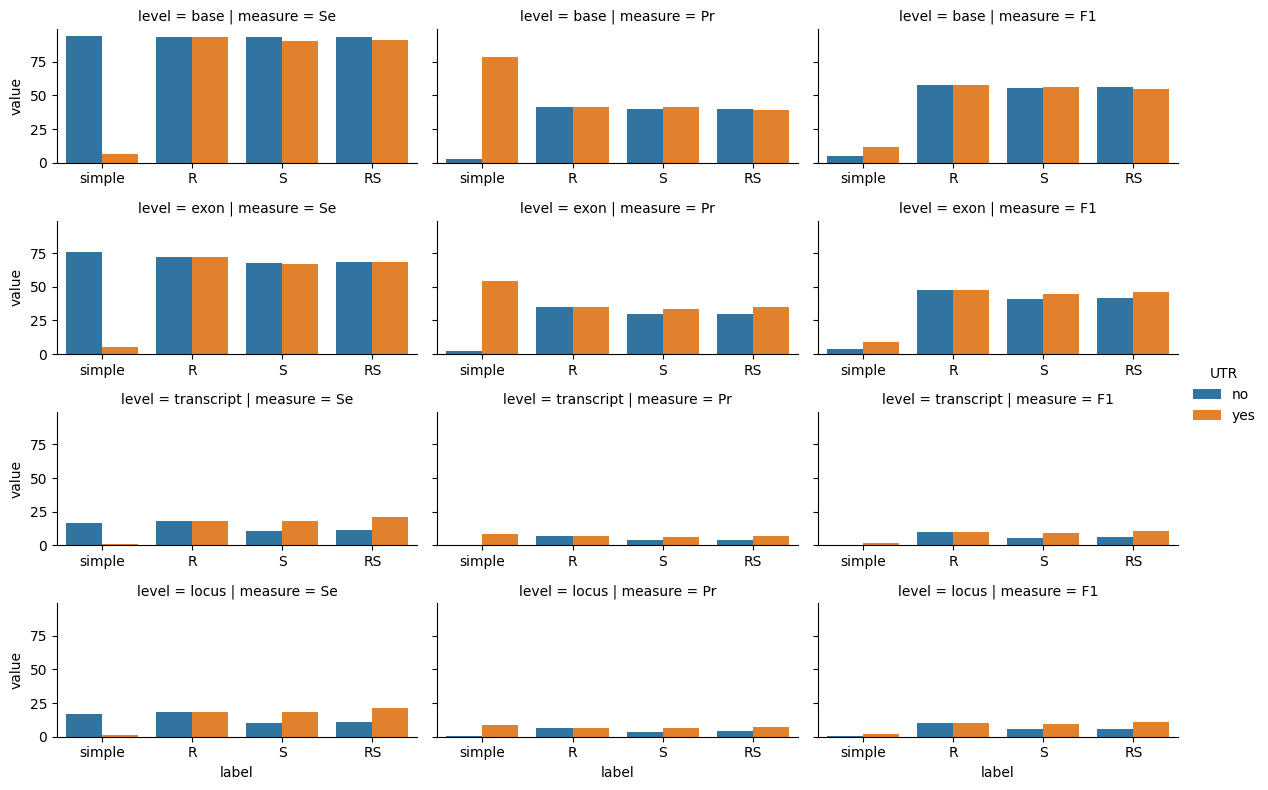

In [103]:
import seaborn as sns
sns.catplot(data = gffcompare_df,
           x = 'label',
           order = ['simple', 'R', 'S', 'RS'],
           y = 'value',
           col = 'measure',
           row = 'level', 
           hue = 'UTR',
           kind = 'bar', 
           # sharey = False,
           sharex = False,
           aspect=2, 
           height=2
           )

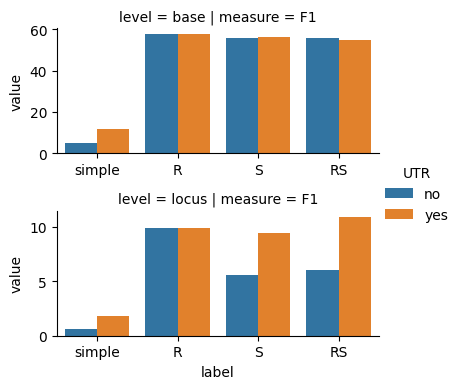

In [104]:
import seaborn as sns
sns.catplot(data = gffcompare_df,
           x = 'label',
           order = ['simple', 'R', 'S', 'RS'],
           y = 'value',
           col = 'measure',
           col_order = ['F1'],
           row = 'level',
           row_order = ['base', 'locus'],   
           hue = 'UTR',
           kind = 'bar', 
           sharey = False,
           sharex = False,
           aspect=2, 
           height=2
           )